# RadFil Tutorial
This tutorial walks through all the steps you need in order to build and fit your own radial density profiles. Please run it in Python 2! Support for Python 3 will come in the future. For this tutorial, our filament of choice is the Musca infrared dark cloud, whose density profile has already been analyzed in [Cox et al. 2016](http://www.aanda.org/articles/aa/pdf/2016/06/aa27068-15.pdf) using an independent radial density profile code. We are going to apply RadFil code to the same published column density map used in the Cox et al. 2016 study ("HGBS_musca_column_density_map.fits") which can be downloaded from the Herschel Gould Belt Survey archives [here](http://www.herschel.fr/cea/gouldbelt/en/Phocea/Vie_des_labos/Ast/ast_visu.php?id_ast=66). The data for the tutorial is also stored locally in the Tutorial_Data folder. 

The two basic ingredients we need to build profiles using RadFil is a fits image and a fits mask for your filament. The third is the filament spine, across which we will sample the profile. If you already have an existing spine for your filament (e.g. from DisPerSE) you can input the spine into RadFil. If not, you can ask RadFil to create a spine for you by performing medial axis skeletonization on your inputted mask; this is done via the [FilFinder package](https://github.com/e-koch/FilFinder).

Even if you input your own spine, in most cases mask is requisite because RadFil searches for the pixel of maximum column density along each cut, bounded by the mask, and then shifts the profile to the maximum value. This ensures that your resulting profile is always centered at r=0 pc. In rare cases that you have a spine and want to shift the profile (but don't have a mask), you can indicate a maximum radial distance from the spine with which to search for the peak column density, and RadFil will make your mask for you. We will get to that a bit later. Let's get started! 

First, we are going to read in our fits image and fits mask (created by applying a simple 2-sigma contour to the fits image) via astropy. If you have it, be sure to read in the header in addition to the image array, as RadFil uses that to determine the image scale. The size of the image array and the mask array must be identical. 

//anaconda/lib/python2.7/site-packages/matplotlib/colors.py:1018: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


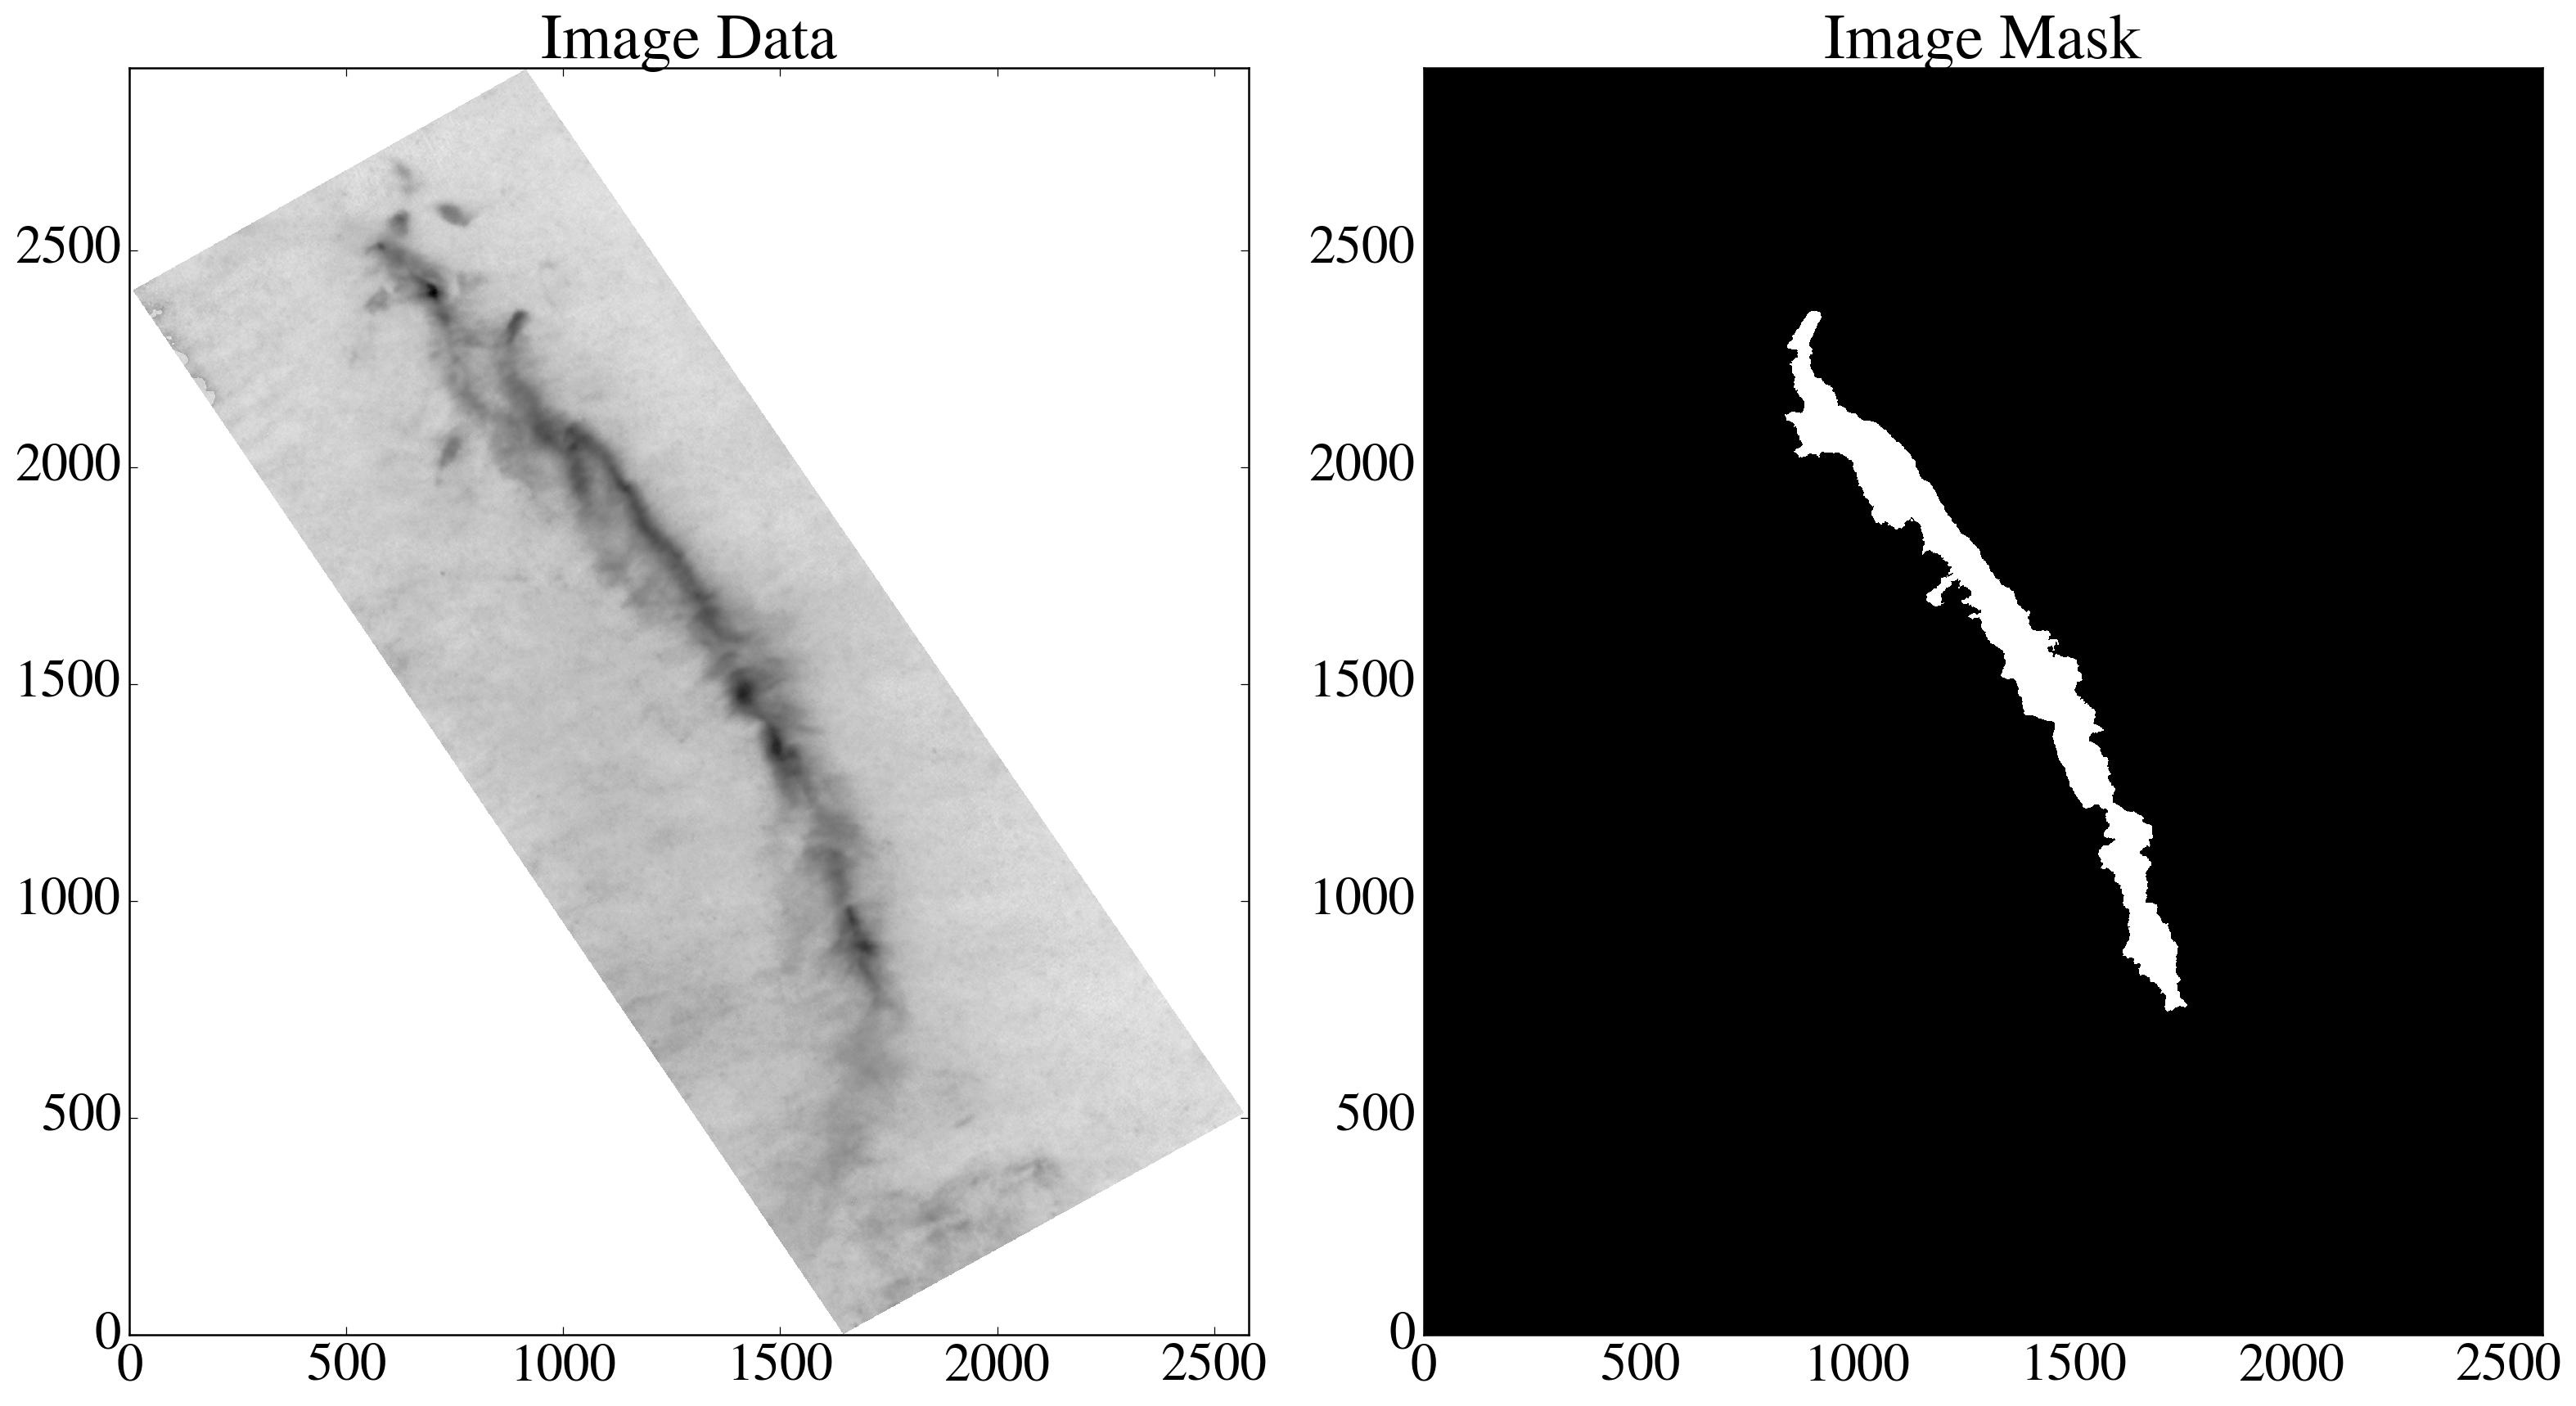

In [1]:
%matplotlib inline

from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from radfil import radfil_class, styles
from astropy import units as u
import warnings
import numpy as np


#reload(radfil_class)
#warnings.filterwarnings('ignore')



fil_image,fil_header=fits.getdata("./Tutorial_Data/HGBS_musca_column_density_map.fits", header=True)
fil_image=fil_image
fil_mask=fits.getdata("./Tutorial_Data/Musca_mask.fits").astype(bool)

#plot our image and mask
fig, ax = plt.subplots(figsize=(20,10), ncols = 2)

ax[0].imshow(fil_image,origin='lower',cmap='Greys',norm=LogNorm())
ax[0].set_title("Image Data")

ax[1].imshow(fil_mask, origin="lower",cmap='Greys_r')
ax[1].set_title("Image Mask")

Now let's set up our radfil object. The first required argument is the image array (type numpy.ndarray). The second required argument is a mask array of the same shape (type numpy.ndarray); the only time the mask is not required is if you provide a filament spine via the "filspine" argument upon instantiating the object. A fits header and a distance to the filament (in pc) are optional, but are necessary if you want to carry out the analysis in physical units and not pixel units. We are going to adopt the same distance for Musca as in Cox et al. 2016 (200 pc) and carry out the analysis in physical units. 

In [2]:
radobj=radfil_class.radfil(fil_image, mask=fil_mask, header=fil_header, distance=200)

Because we don't have a spine, we're going to make one using the FilFinder package from [Koch & Rosolowsky (2015)](https://academic.oup.com/mnras/article-abstract/452/4/3435/1058975/Filament-identification-through-mathematical?redirectedFrom=fulltext), which can be downloaded [here](https://github.com/e-koch/FilFinder). They create filament spines by reducing the image mask to a one-pixel wide topological representation of the mask using medial axis skeletonization. The only additional parameter we need to provide FilFinder is the beamwidth of our image in arcseconds, which in Musca's case is 36.3". The verbose argument indicates whether you want FilFinder to output all the skeletonization plots. 

In [3]:
radobj.make_fil_spine(beamwidth=36.3,verbose=False)
fits.writeto("./Tutorial_Data/Musca_spine.fits", radobj.filspine.astype(int), clobber=True)

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Creating the filament spine could take awhile, because the image is very large. Once it's done, your radobj will now have an attribute called filspine, which is the boolean array demarcating the one-pixel wide spine. Once you created your spine the first time, just write it out as a fits image and read it into your radobj object above (as the filspine parameter) the next time around to avoid having to create the spine again. Here's what the spine looks like: 

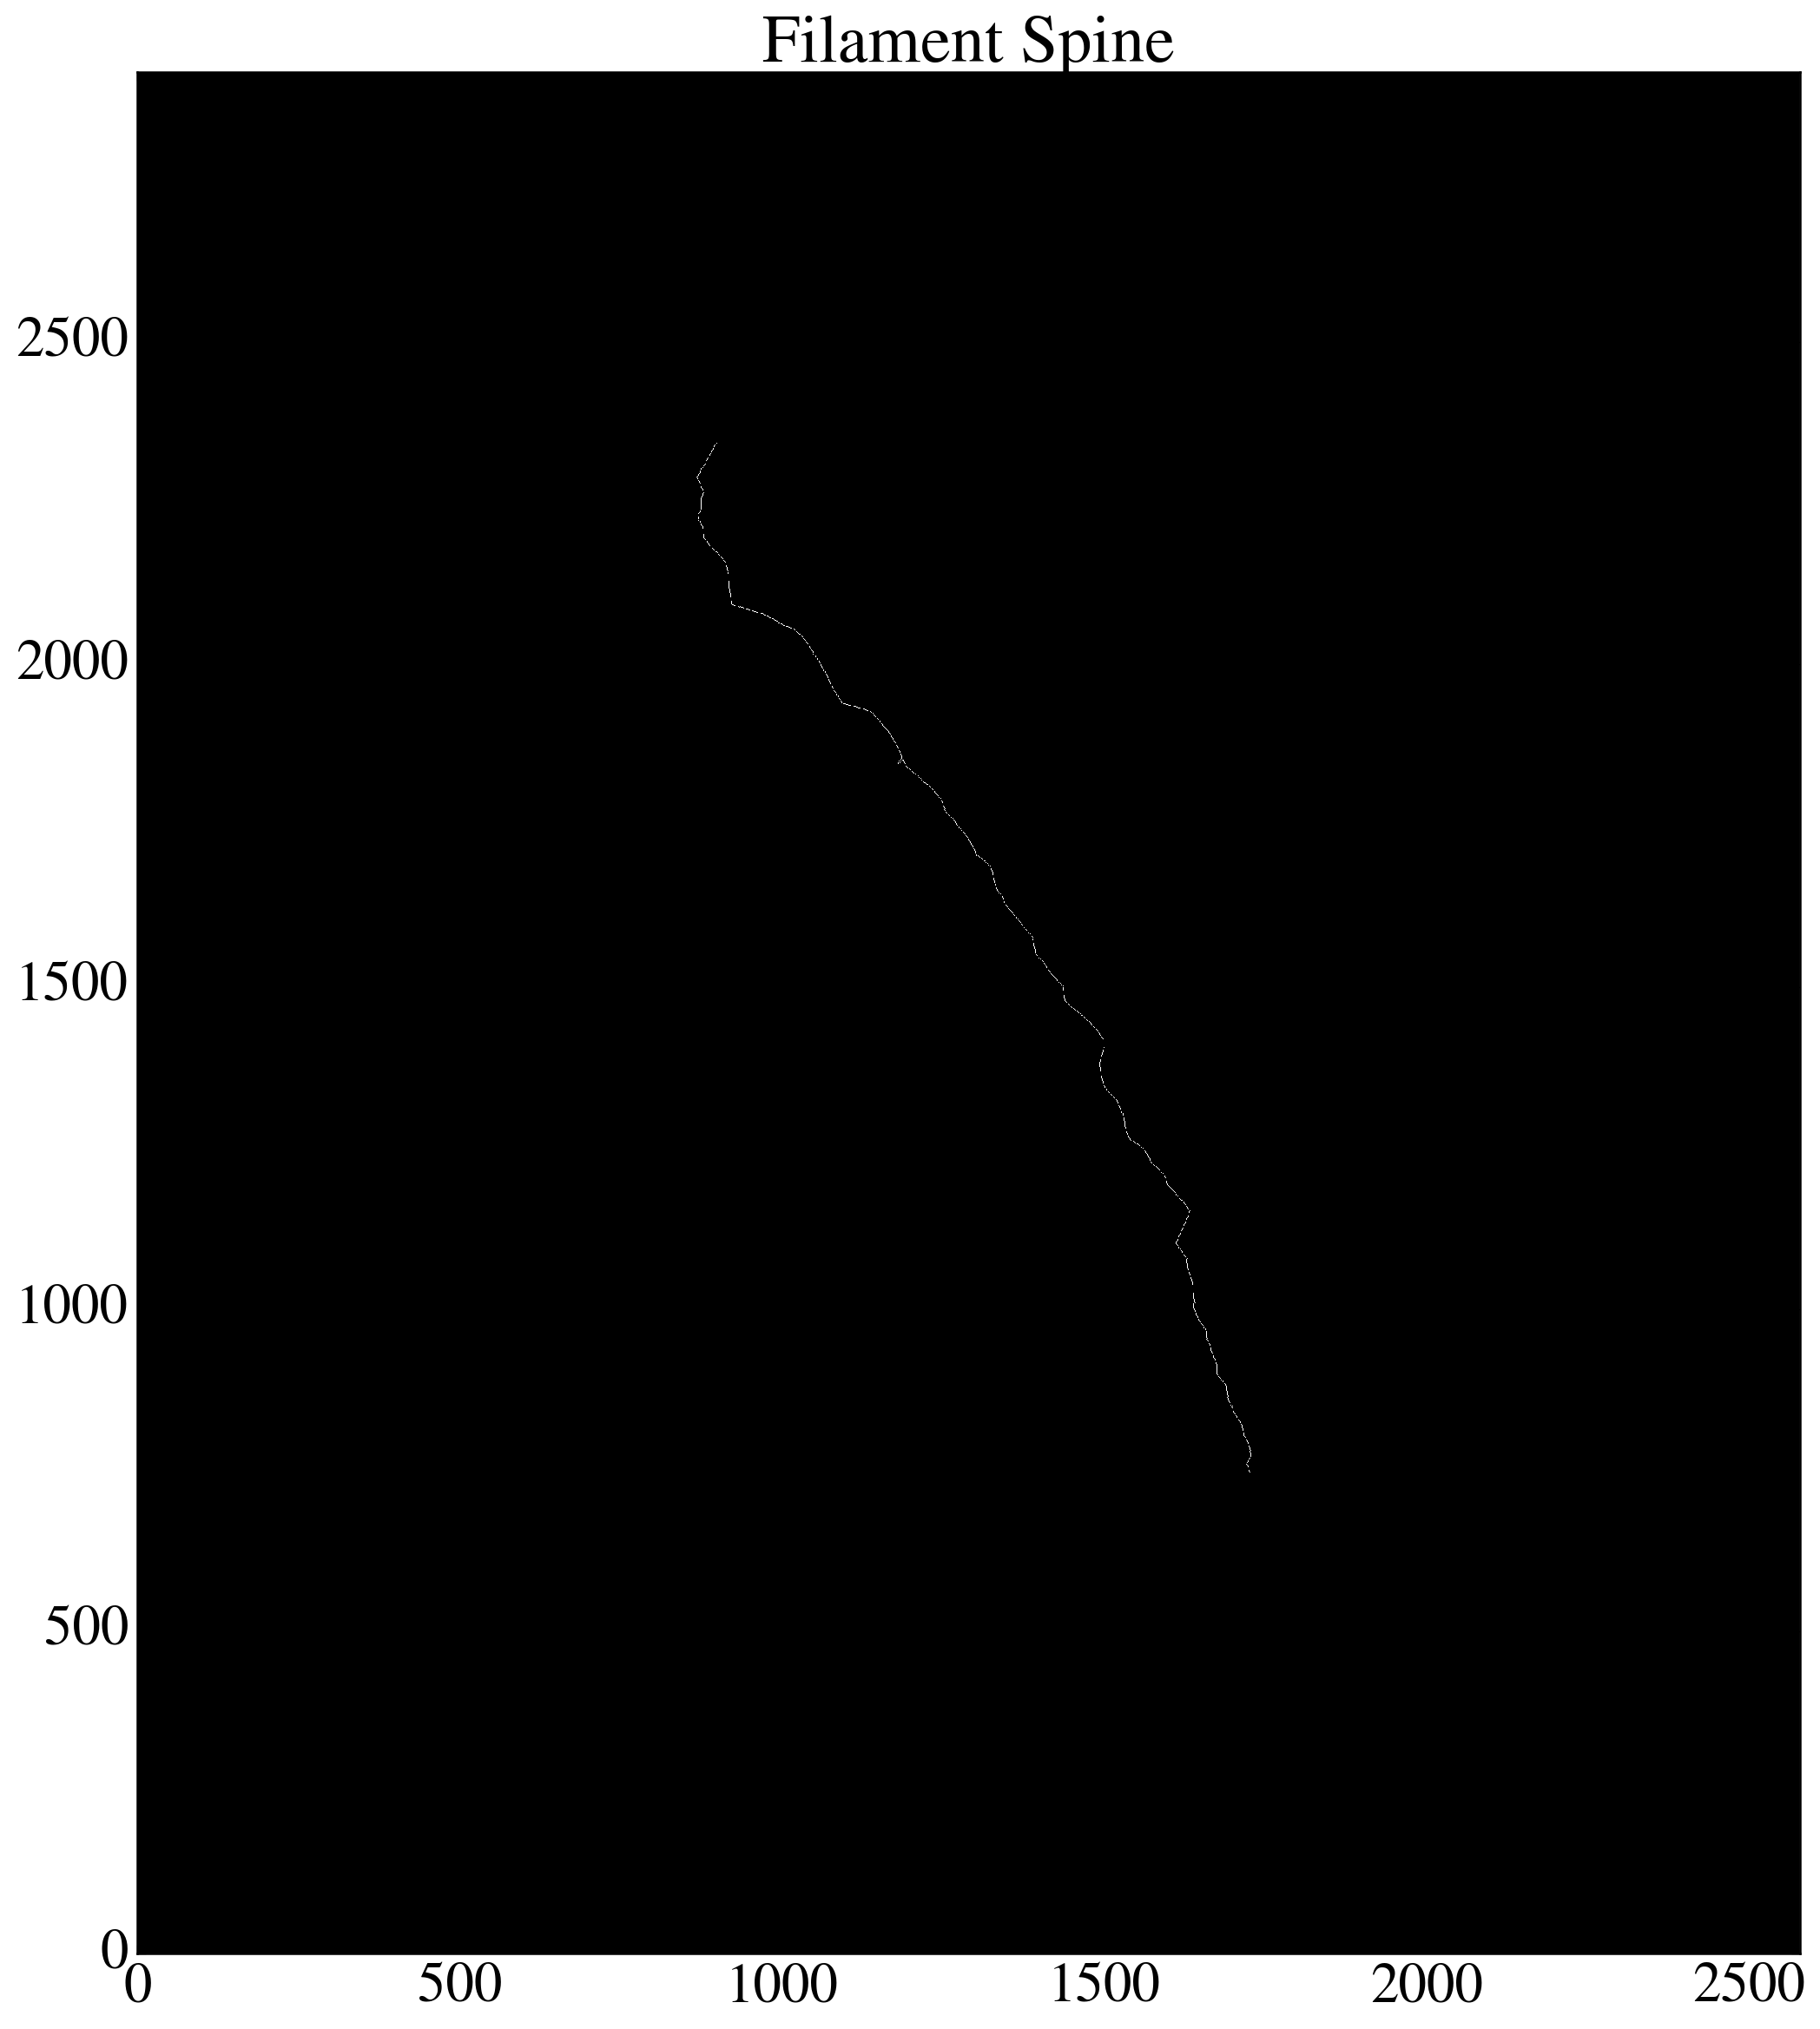

In [10]:
fig=plt.figure()
ax=fig.gca()

ax.imshow(radobj.filspine.astype(int), cmap="binary_r", origin='lower')
ax.set_title("Filament Spine")
fig.set_dpi(500)


Running the make_fil_spine command also returns the length of the filament, which can be accessed under the radobj.length attribute:

In [11]:
print("The Musca filament is {:.1f} long".format(radobj.length))

The Musca filament is 8.2 pc long


Now that we have everything we need, let's briefly walk through how RadFil builds these profiles. RadFil starts by smoothing the filament spine outputted by the FilFinder program (or DiSperSe), taking the derivative across the spine, and making cuts perpendicular to tangent lines sampled evenly across the smoothed spine. The spine smoothing is necessary because the original spines often do not have a smooth continuous derivative, so perpendicular cuts made locally might not reflect the global curvature of the filament. Smoothing the spines and sampling the cuts is a multi-step process. We start by collecting all pixels in filspine belonging to our original spine and use python’s networkx module to sort the array by the order in which they lie along the spine path. As the filament spines are often non-monotonic, we parameterize them using not only their x and y values, but also this order along the path "t". We then use scipy.interpolate’s splprep function to determine a B-spline representation of the spine, applying a smoothness condition to remove kinks in the original spine. Next, we use scipy.interpolate’s splev function to take the first derivative of the spine and evaluate the local curvature across its entire length. Finally, we make fine cuts across the spine by selecting tangent points at well-sampled intervals, parameterizing the tangent lines at these points, and then taking cuts perpendicular to these tangent lines. 

We build the profiles using the build_profile method, which takes a few optional arguments. Here is a brief explanation of the major features:

- **samp_int** -- determines how finely you'd like to make cuts across the spine. Inputted as an integer, this indicates the approximate distance between cuts in pixels (samp_int=25 means the cuts are ~25 pixels apart, or 25 x imgscale in pc). You can always determine the image scale of your image by typing "radobj.imgscale," and it will return the value in pc (or pixel units, if no distance is provided). Since radobj.imgscale for Musca=.00387, we are sampling ~ every 0.10 pc in the cell below
- **bins** -- indicates whether you want to average the profile heights in discrete radial bins, or whether the profiles should remain unbinned. If you choose to bin, you can enter bins as an integer (number of bins, from the minimum radial distance sampled to the maximum radial distance sample) or as an array indicating the bin edges.  If "none", no binning is applied. *Note that if you choose to been, the fitting will be performed on the single (bin-averaged) profile.* 
- **shift** -- whether the center of the profile along each cut should be shifted to the pixel with the maximum column density. RadFil searches the region of the cut confined within the filament mask to determine which one has the peak column density. That pixel then becomes r=0 pc and the profiles are built out from there. The default is True.
- **pts_mask** -- use this argument if you want to exclude certain spine points from the profile analysis. For instance, if you have a filament that loops around on itself at either end (producing overlapping cuts) and you want to exclude this region from the profile, provide pts_mask as a 2D boolean array of the same shape as the image, where the loop region is False and all other regions are True.
- **cutdist** -- this is used in rare cases where you input a spine without a mask and want to shift the profile. If this happens, you have to enter "cutdist"; this creates a mask for you by finding all points within a distance "cutdist" of the spine. 


For now we are just going to build a profile with a) sampling interval of 25 b) shifting (the default) c) no point masking and d) no binning.


No binning is applied.


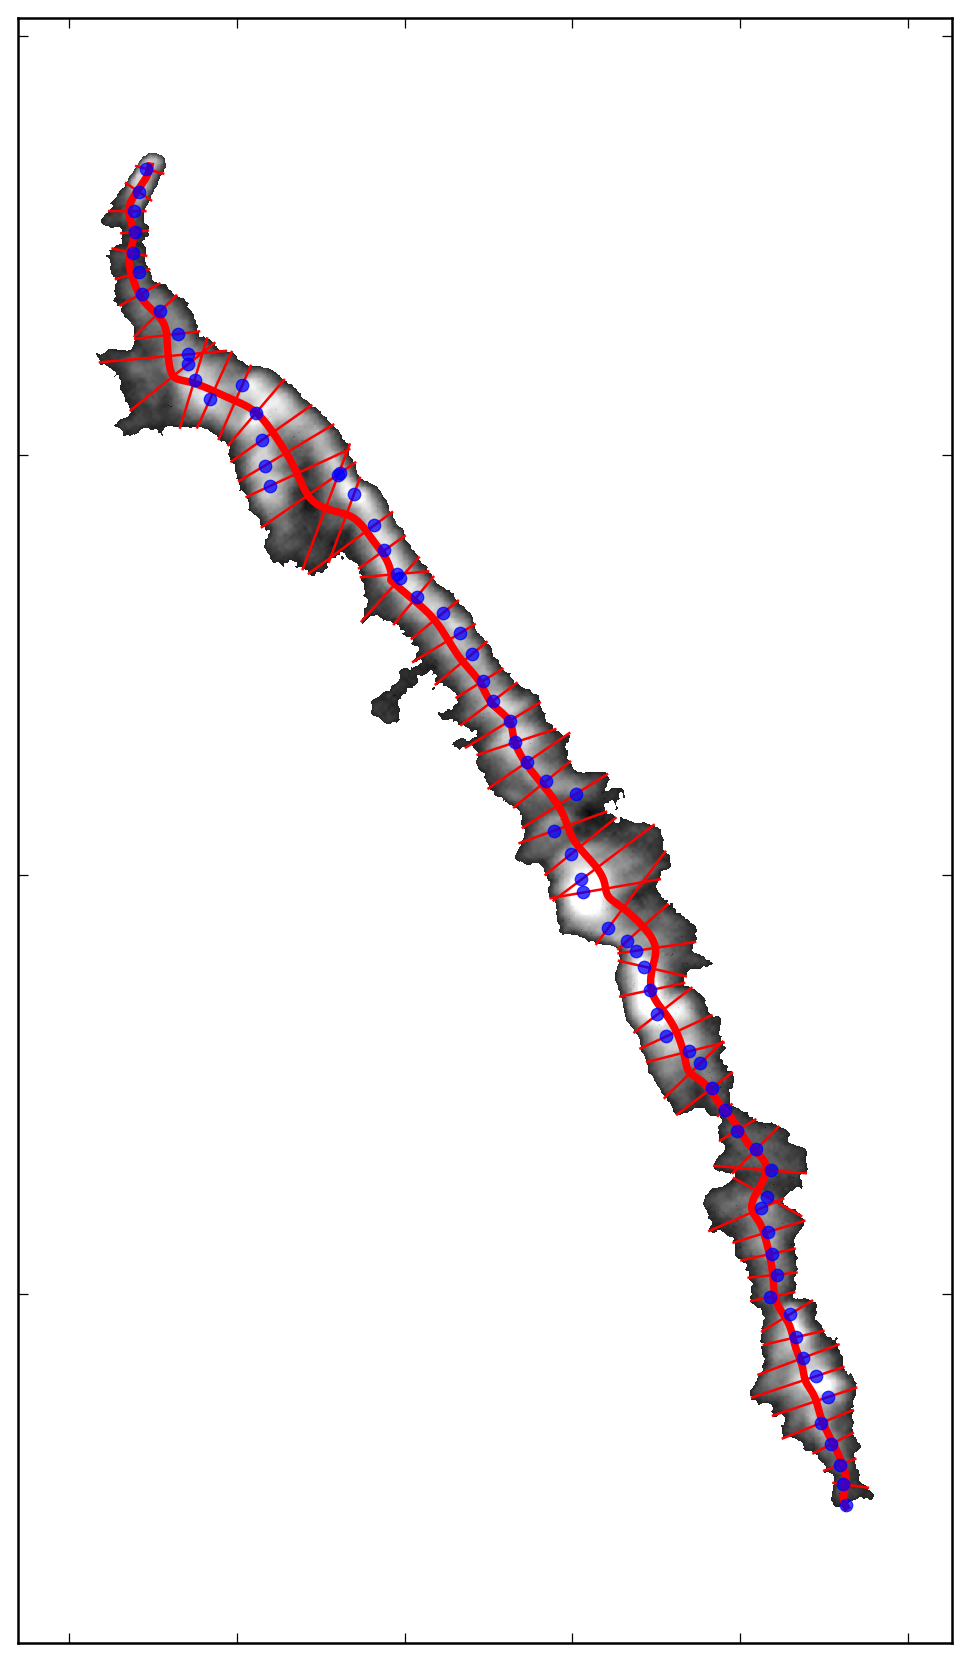

In [12]:
radobj.build_profile(samp_int=25)
plt.gcf().set_size_inches(18.5, 10.5)

In the figure above, the background grayscale shows the underlying column density of the filament within the mask. The thick red line is the smoothed spine of the filament. The perpendicular red cuts are taken at approximately 0.1 pc intervals tangent to the smoothed spine. Because "shift=True" by default, each cut is shifted to the peak column density along the cut, which are marked via the blue scatter points. 

<!--The top figure in the above panel shows the smoothed spine as a thick red line running down the original filament mask, with the perpendicular cuts across the spine also shown in red. RadFil searches for the pixel with maximum column density along each of the perpendicular red cuts ("local width lines") which are marked with a blue dot. RadFil then shifts the center of the profile to this pixel, and builds the radial column density profile out from that point.

The bottom profile shows overlays the radial column density profile for each of the red cuts in the top panel. To create the "master" representative profile shown in red, RadFil linearly interpolates between the points in each of the original profiles, bins them by radial distance from the spine, and takes the median column density in each bin. You can change the number of bins that the profile is divided into (from -cutdist to +cutdist) by changing the numbins parmater above! -->

Now that we have built the profile, we have access to a lot of additional attributes. We can the retrieve information on the radial distances and density profiles of each cut via the "dictionary_cuts" attribute. To access the radial distances of each cut, we can use "radobj.dictionary_cuts['distance']" which will return a list the same size as the number of cuts. To access the profile heights at each of the distances, we can use "radobj.dictionary_cuts['profile']". To access the "master profile" (i.e. the average profile in the case of binning, or every single point in the array of profiles concatenated into a list for no binning), we can use radobj.masterx and radobj.mastery:

No labelled objects found. Use label='...' kwarg on individual plots.


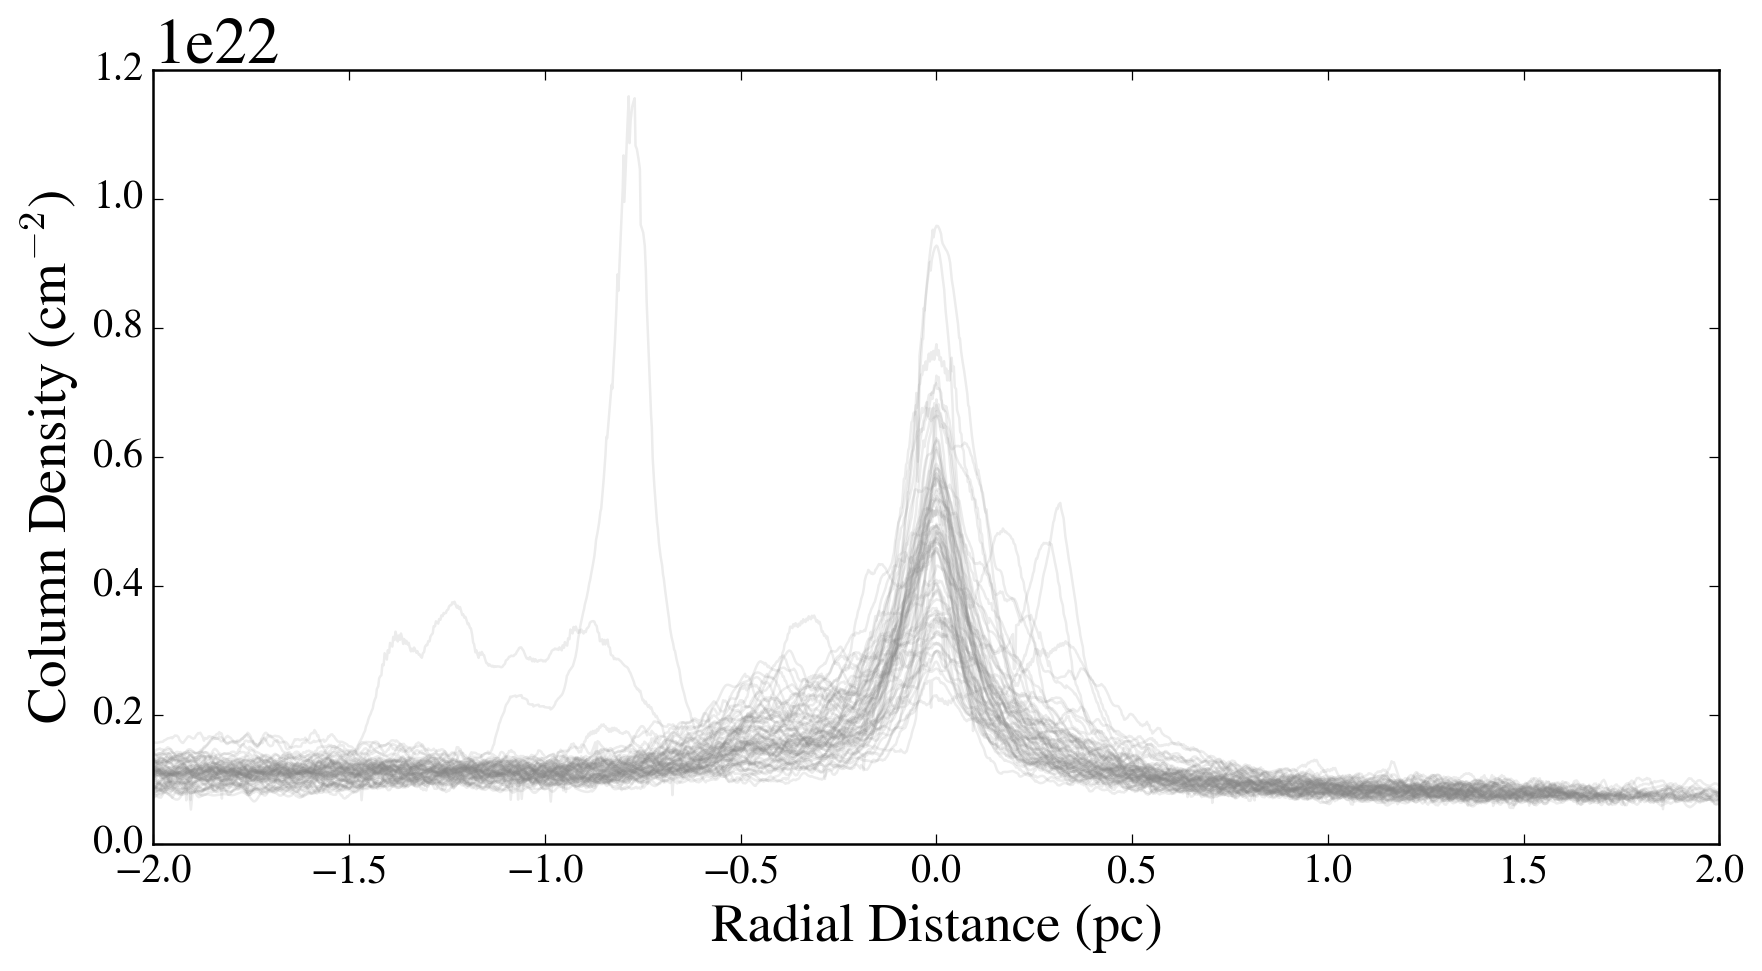

In [13]:
fig=plt.figure(figsize=(10,5))

#plot the profile of each cut 
for i in range(0,len(radobj.dictionary_cuts['distance'])):
    plt.plot(radobj.dictionary_cuts['distance'][i], radobj.dictionary_cuts['profile'][i],c='gray',alpha=0.15)
    
plt.xlim(-2,2)
plt.legend(fontsize=15)
plt.xlabel("Radial Distance (pc)",fontsize=22)
plt.ylabel(r"Column Density (cm$^{-2}$)",fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=16)


Another useful attribute retrievable after building the profile is the "mask_width" attribute. This returns a list containing the width of each "local width cut," i.e. the length of each of the red cuts across the spine, confined within the filament mask. If you take an average of these values, it gives you an average mask-based width of the filament. This can be relevant in cases where you cannot reliably fit a profile, but still want to approximate a width of some contour. 

In [14]:
print("The average mask-based width of Musca is {:.2f} pc".format(np.nanmedian(radobj.dictionary_cuts['mask_width'])))

The average mask-based width of Musca is 0.34 pc


Now that we have the master profile, we are ready for fitting using the fit_profile method. RadFil comes with two built in models for fitting: a Gaussian-like model and a Plummer-like model, the latter of which is given in Cox et al. 2016. For both models we can also choose whether we would like to fit and subtract a background. For now, we are going to fit both a Plummer-like fit and a Gaussian fit after doing some background subtraction. We have two options for background subtraction which we control via the 'bgdegree" argument:

- bgdegree=0 indicates you want to fit a flat line (zeroeth order polynomial)
- bgdegree=1 indicates you want to fit a sloping line (first order polynomial). This is the default.

We choose the sloping background option (bgdegree=1). This will fit a line on either side of your profile within the bounds of the "bgdist" parameter, which specifies the inner and outer radial distances over which to perform the background fit. We adopt inner and outer background radii of 1 and 2 pc. Thus, we input bgdist=(1,2). Finally, after performing the subtraction, we will fit the Plummer-like function out to a distance of 1 pc, which we indicate via the fitdist=1 argument. The range of radii over which the background and Plummer-functions are fit are highlighted in green and blue in the figures below.

==== Plummer-like ====
amplitude: 3.777E+21
p: 2.257
R_flat: 0.078
Physical Size of the Beam: 0.0351974732486 pc


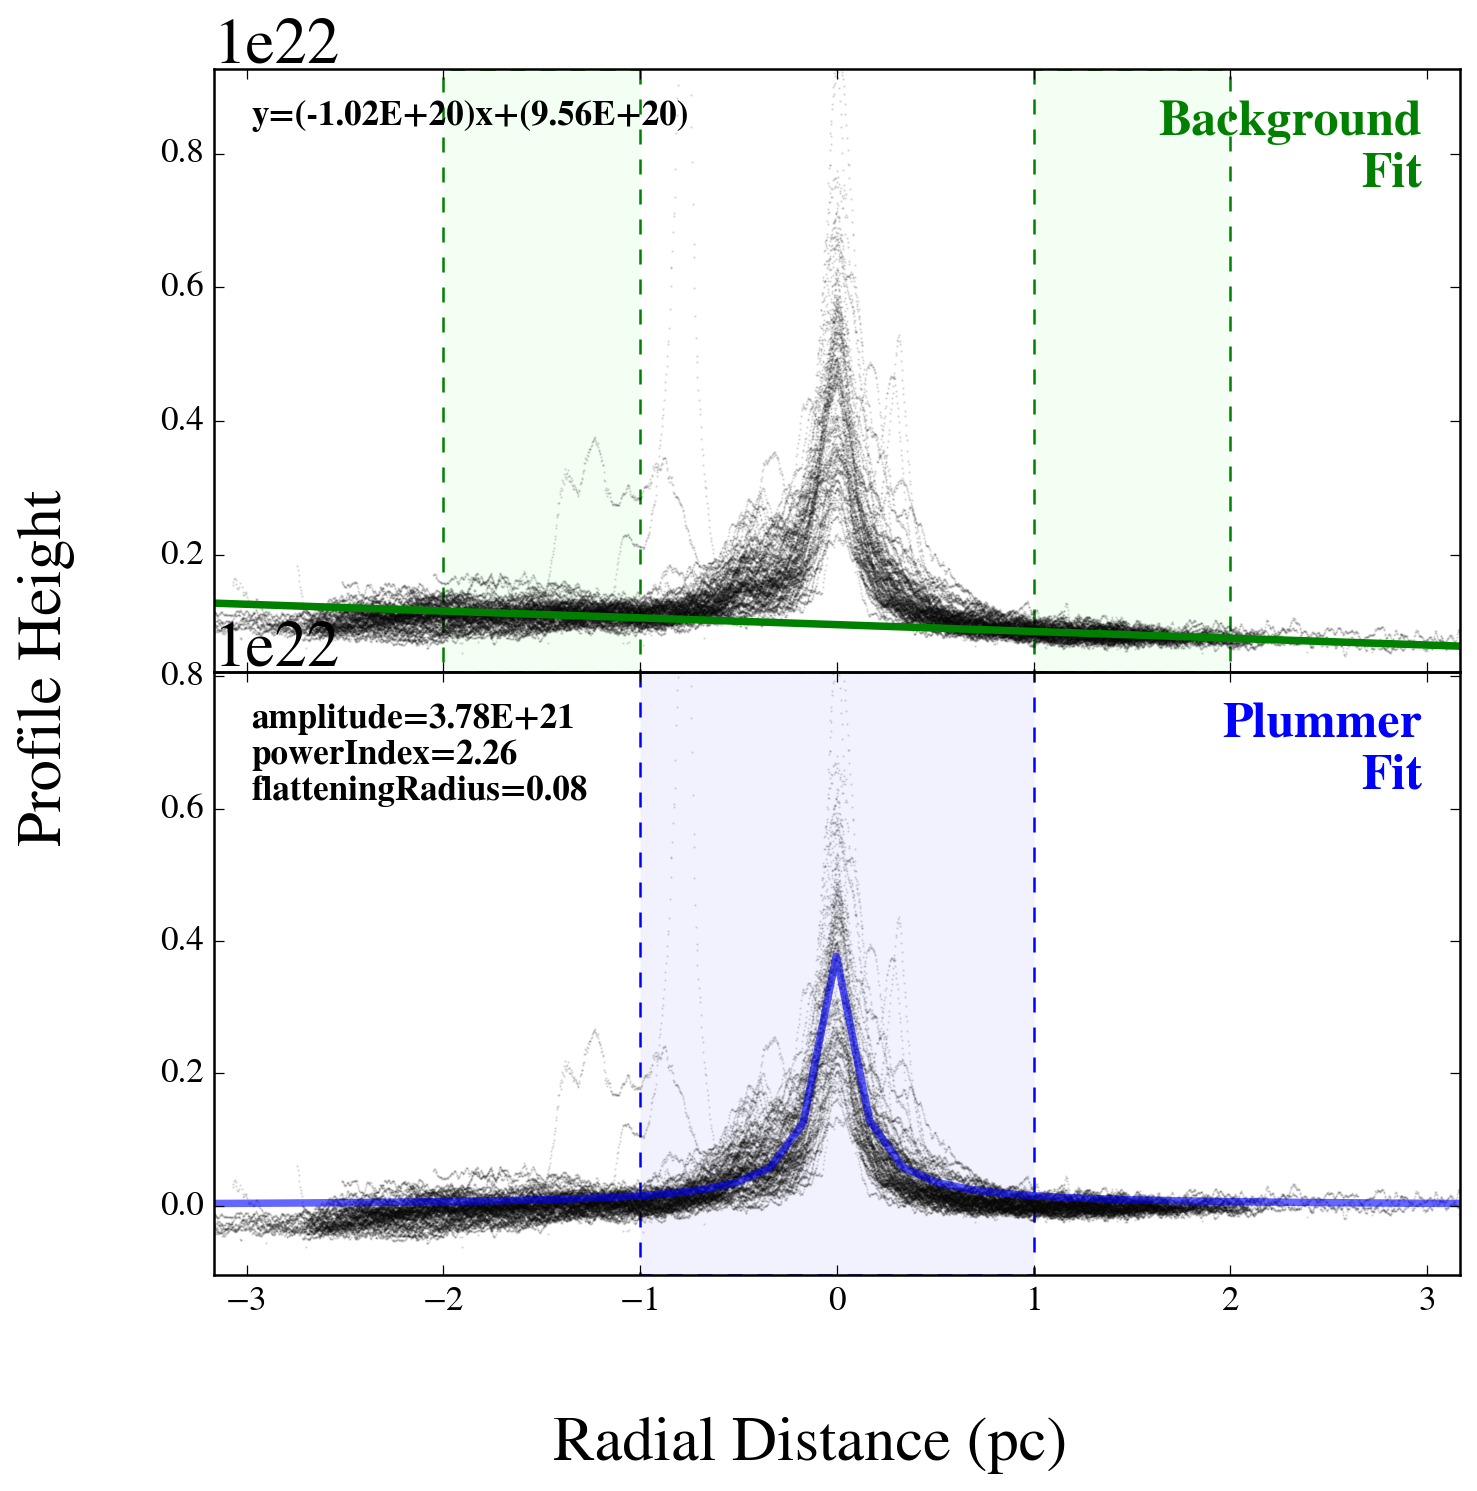

In [15]:
radobj.fit_profile(fitfunc="Plummer",fitdist=1.0,bgdist=(1.0,2.0),bgdegree=1, beamwidth=36.3)


You can now access the best-fit values for the background fit via the "bgfit" attribute:

In [16]:
radobj.bgfit

<Polynomial1D(1, c0=9.557349967357633e+20, c1=-1.0156294353001824e+20)>

And for the Plummer-like fit via the "profilefit" attribute:

In [17]:
radobj.profilefit

<Plummer1D(amplitude=3.776969835878061e+21, powerIndex=2.2567885520672606, flatteningRadius=0.07819795561182843)>

Both are astropy.modeling objects and can be manipulated via the normal channels:

In [18]:
for (name,value) in zip(radobj.profilefit.param_names,radobj.profilefit.parameters):
    print("The best-fit {} is {}".format(name,value))

The best-fit amplitude is 3.77696983588e+21
The best-fit powerIndex is 2.25678855207
The best-fit flatteningRadius is 0.0781979556118


**The values for R_flat and p given in Cox et al. 2016 are R_flat=0.08 pc, p=2.2 +/- 0.3, while we find R_flat=0.08 and p=2.26, which are practically identical to the Cox values and well within the margin of error.**

Next, we are going to fit the inner width of the filament with a Gaussian, using the same background subtraction parameters as in the Plummer-like fit above. However, we will adopt a new fitting distance. In Cox et al. 2016, they fit out to a distance of 0.05 pc (private communication), so we will also fit out to 0.05 pc in order to reproduce their method. 

==== Gaussian ====
amplitude: 3.843E+21
width: 0.067
Physical Size of the Beam: 0.0351974732486 pc


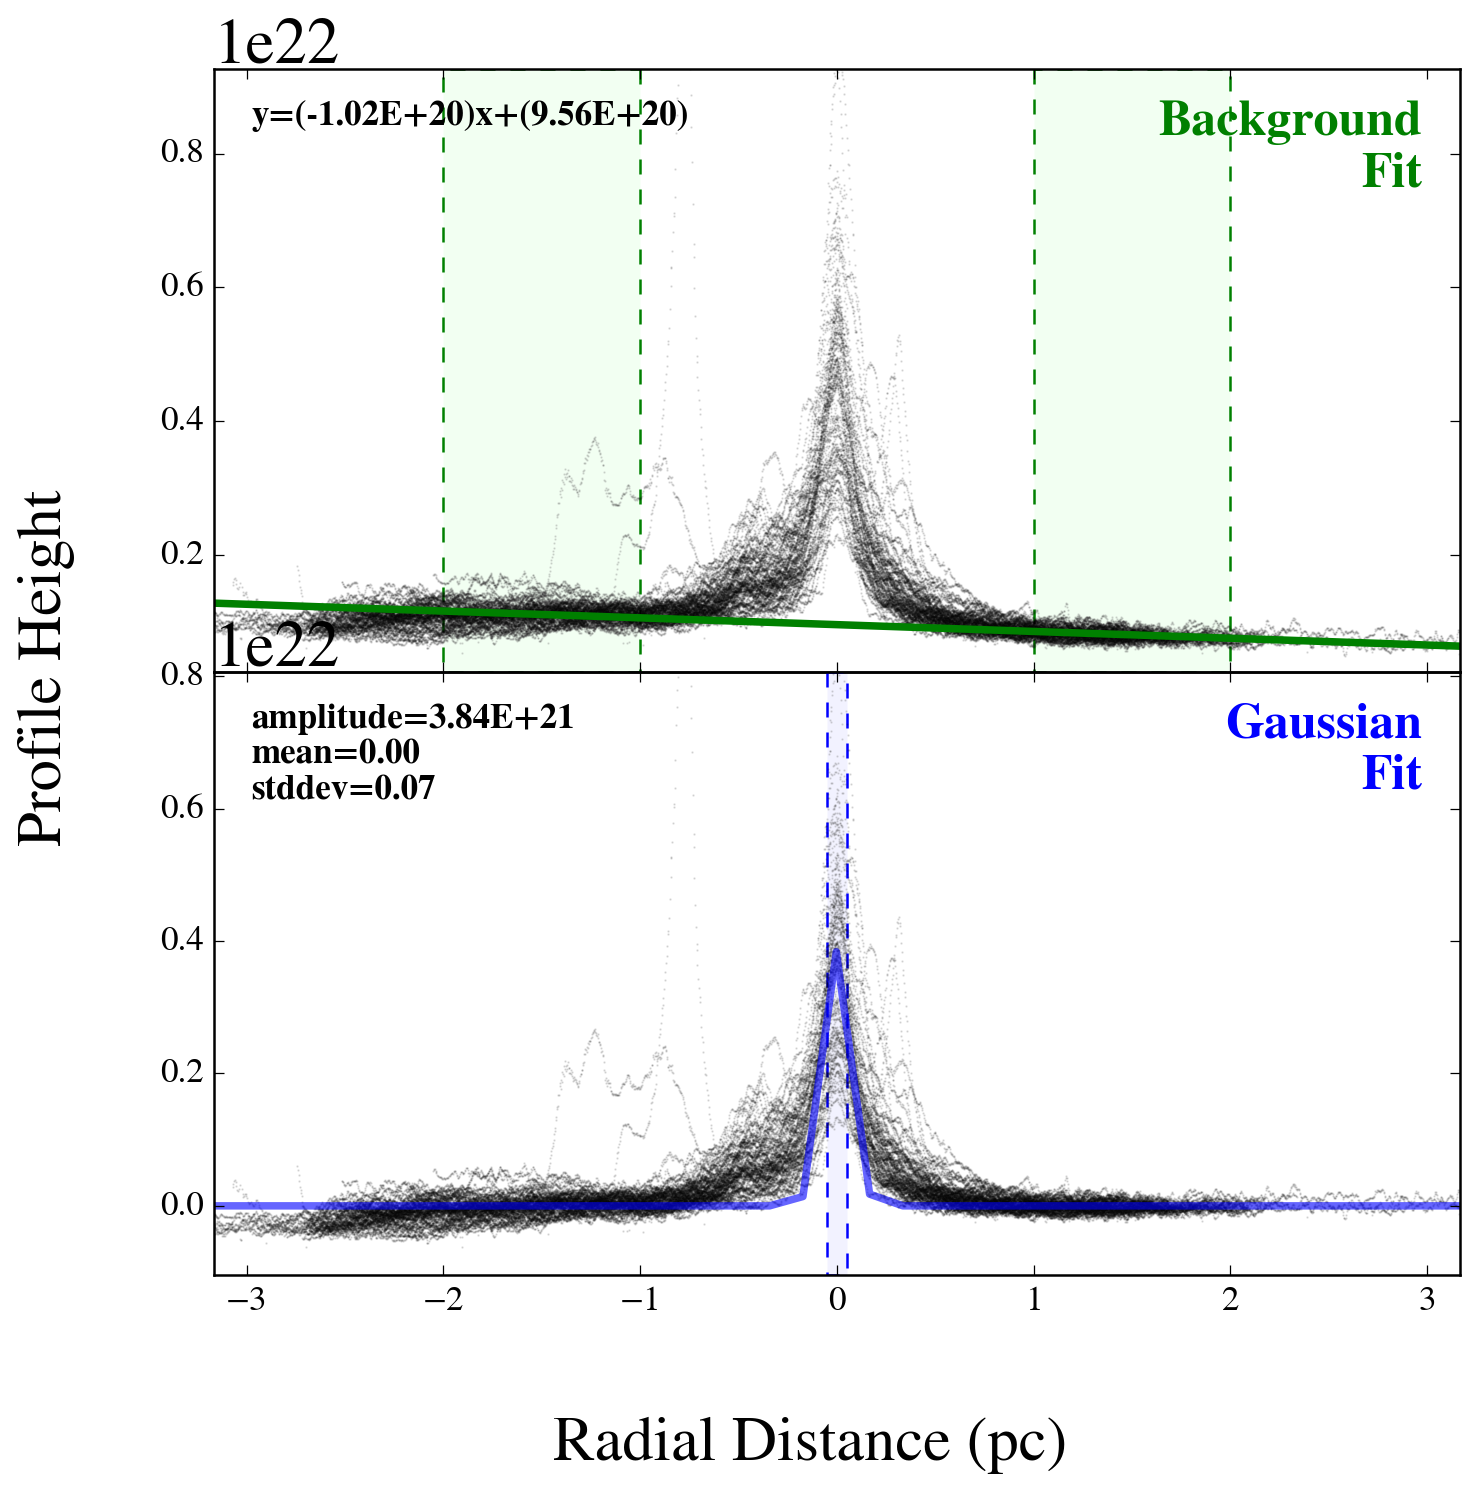

In [19]:
radobj.fit_profile(fitfunc="Gaussian",fitdist=0.05,bgdist=(1.0,2.0),bgdegree=1,beamwidth=36.3)

In addition to providing the best fit standard deviation, running the fit_profile method also automatically calculates the FWHM (both deconvolved and non-deconvolved with the beam). These can be accessed via the radobj.FWHM and radobj.FWHM_deconv attributes. In order to calculate the deconcolved FWHM, you must input the beamwidth in the make_fil_spine method, or (if you enter a pre-computed spine) in the fit_profile method. Otherwise the deconvolved FWHM will be set to nan.

In [20]:
print("The deconvolved FWHM is {:.2f} pc and the non-deconvolved FWHM is {:.2f}".format(radobj.FWHM_deconv,radobj.FWHM))

The deconvolved FWHM is 0.15 pc and the non-deconvolved FWHM is 0.16


**The published Cox et al. 2016 deconvolved FWHM value is 0.14 +/- 0.03 pc while our deconvolved FWHM value is 0.15, so again, our results agree very well with the published value and are within the margin of error. **

____
The resulting plots can be retrieved and plotted to the user's own matplotlib axis instance.  This gives the user the freedom to edit the axis labels, adjust the figure size, and adjust the ticks.  This is done using the plotter class in `RadFil`.

In [21]:
radobj_plotter = radobj.plotter()

For example, the plot for the spline and the cuts can be reproduced to an axis with proper wcs projection:

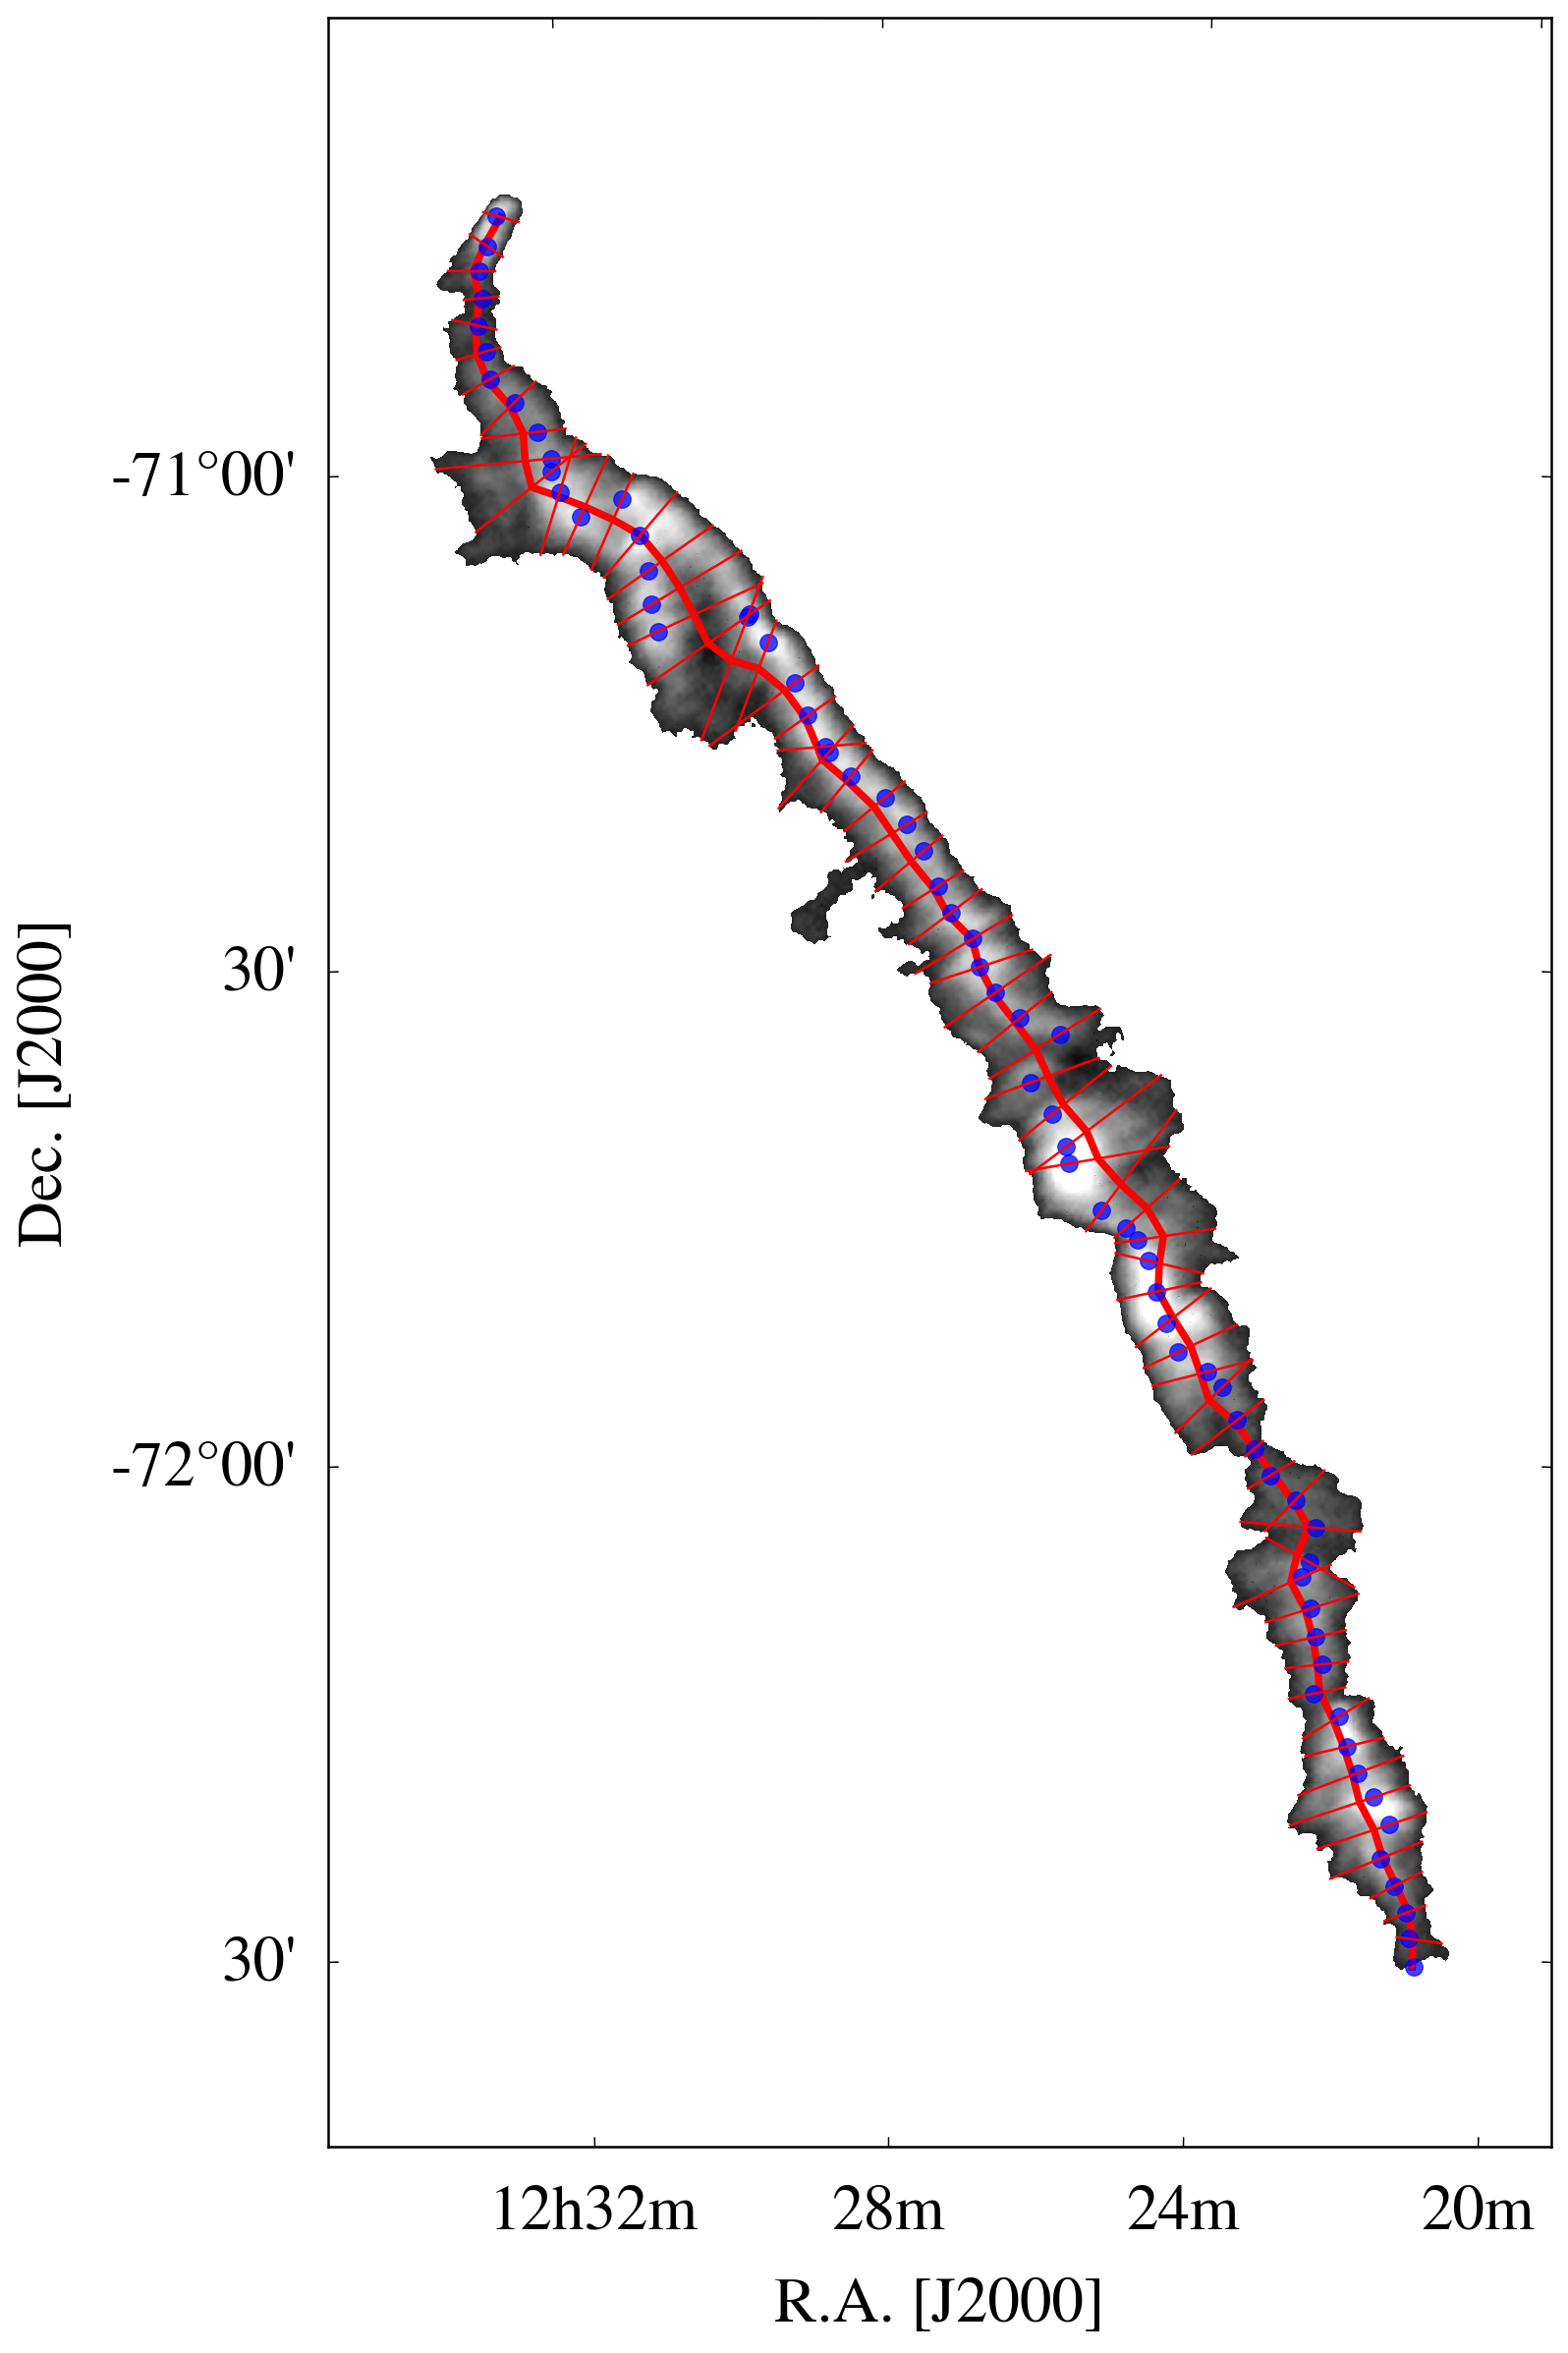

In [22]:
from astropy import wcs

fig = plt.figure()
# Set up the wcs axis.
ax = fig.gca(projection = wcs.WCS(fil_header))
ax.coords[0].set_axislabel('R.A. [J2000]')
ax.coords[0].set_major_formatter('hh:mm')
ax.coords[1].set_axislabel('Dec. [J2000]')

# Plot!!
radobj_plotter.plotCuts(ax)

The user can also retrieve the plots generated during fitting:

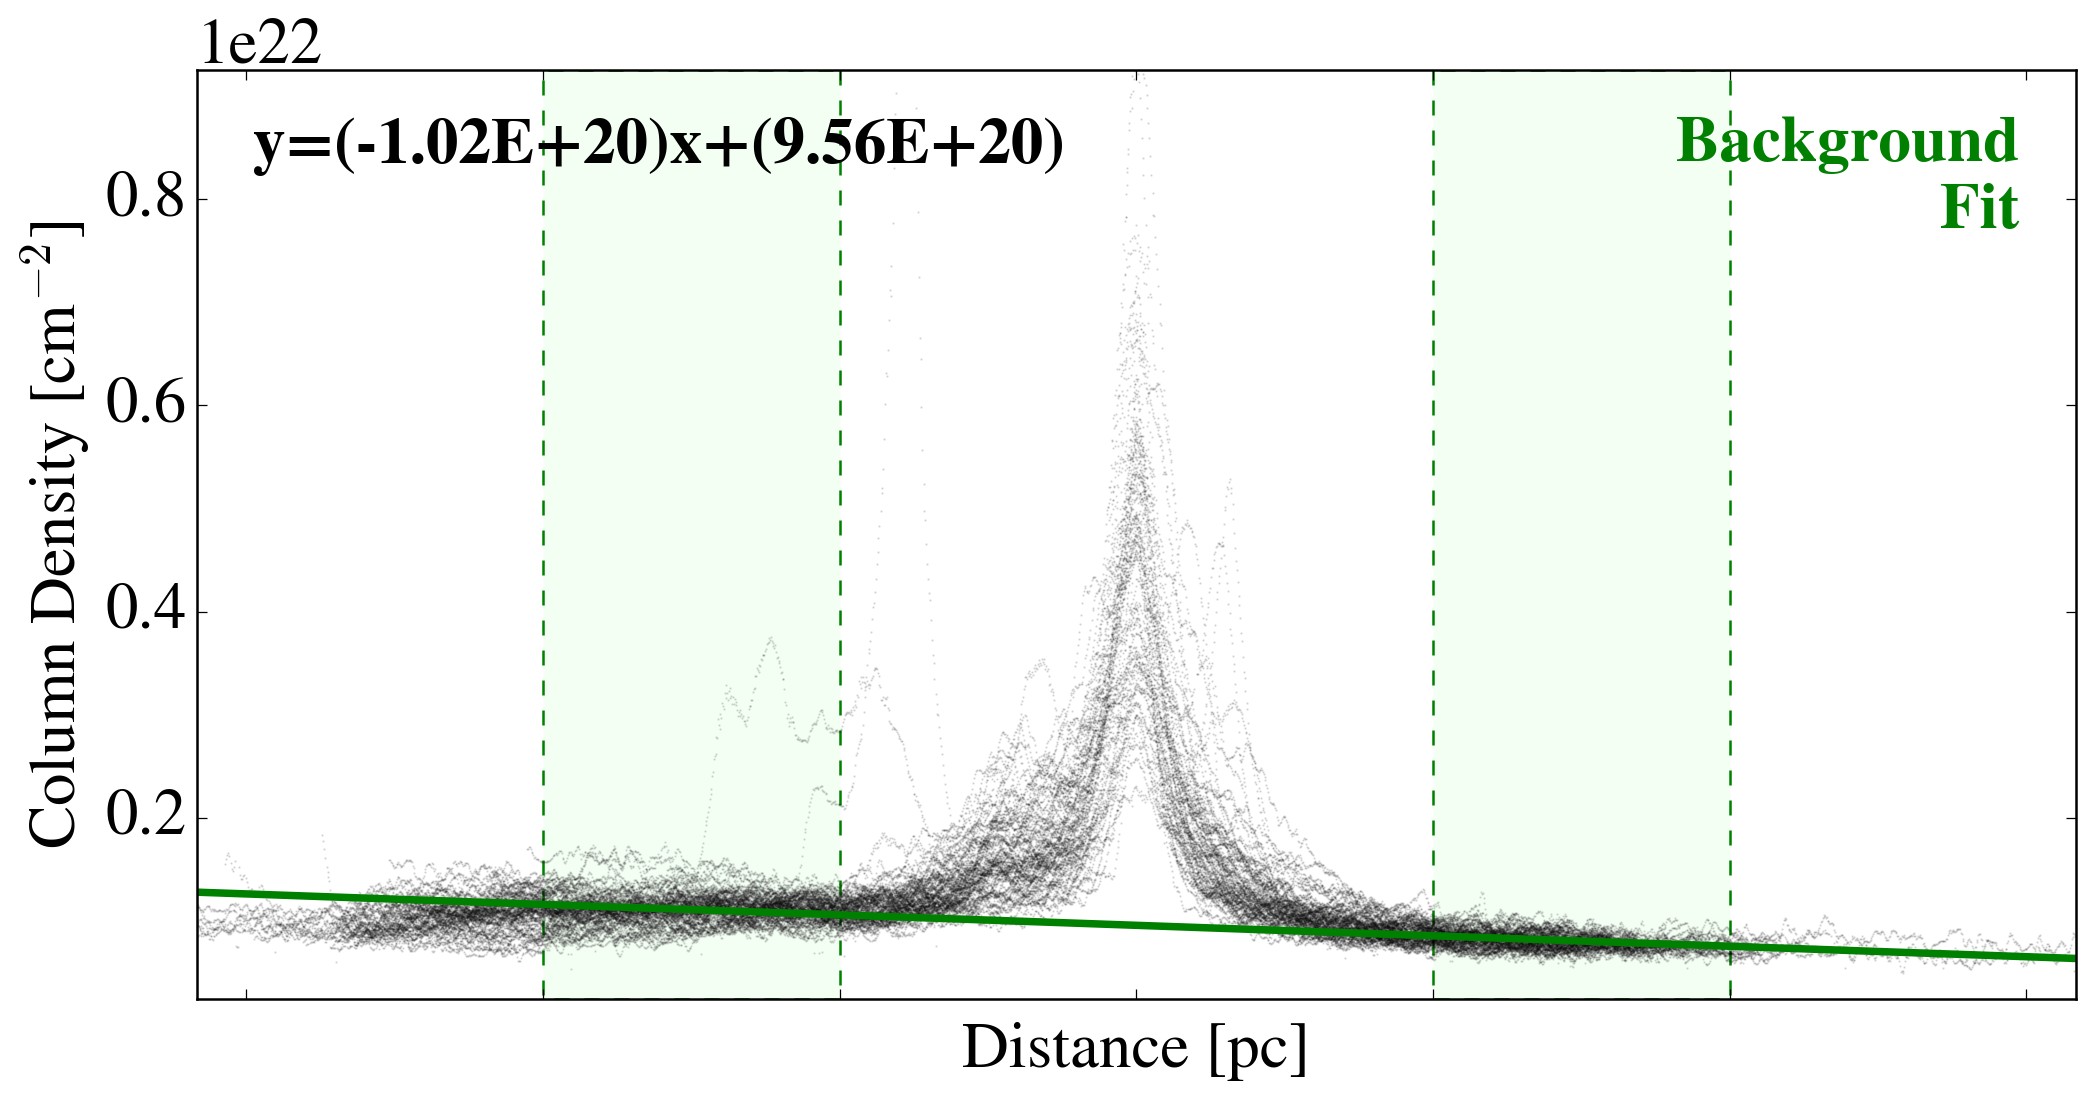

In [25]:
fig = plt.figure(figsize = (12., 6.))
ax = fig.gca()
ax.set_xlabel('Distance [pc]')
ax.set_ylabel('Column Density [cm$^{-2}$]')

radobj_plotter.plotFits(ax, 'bg')

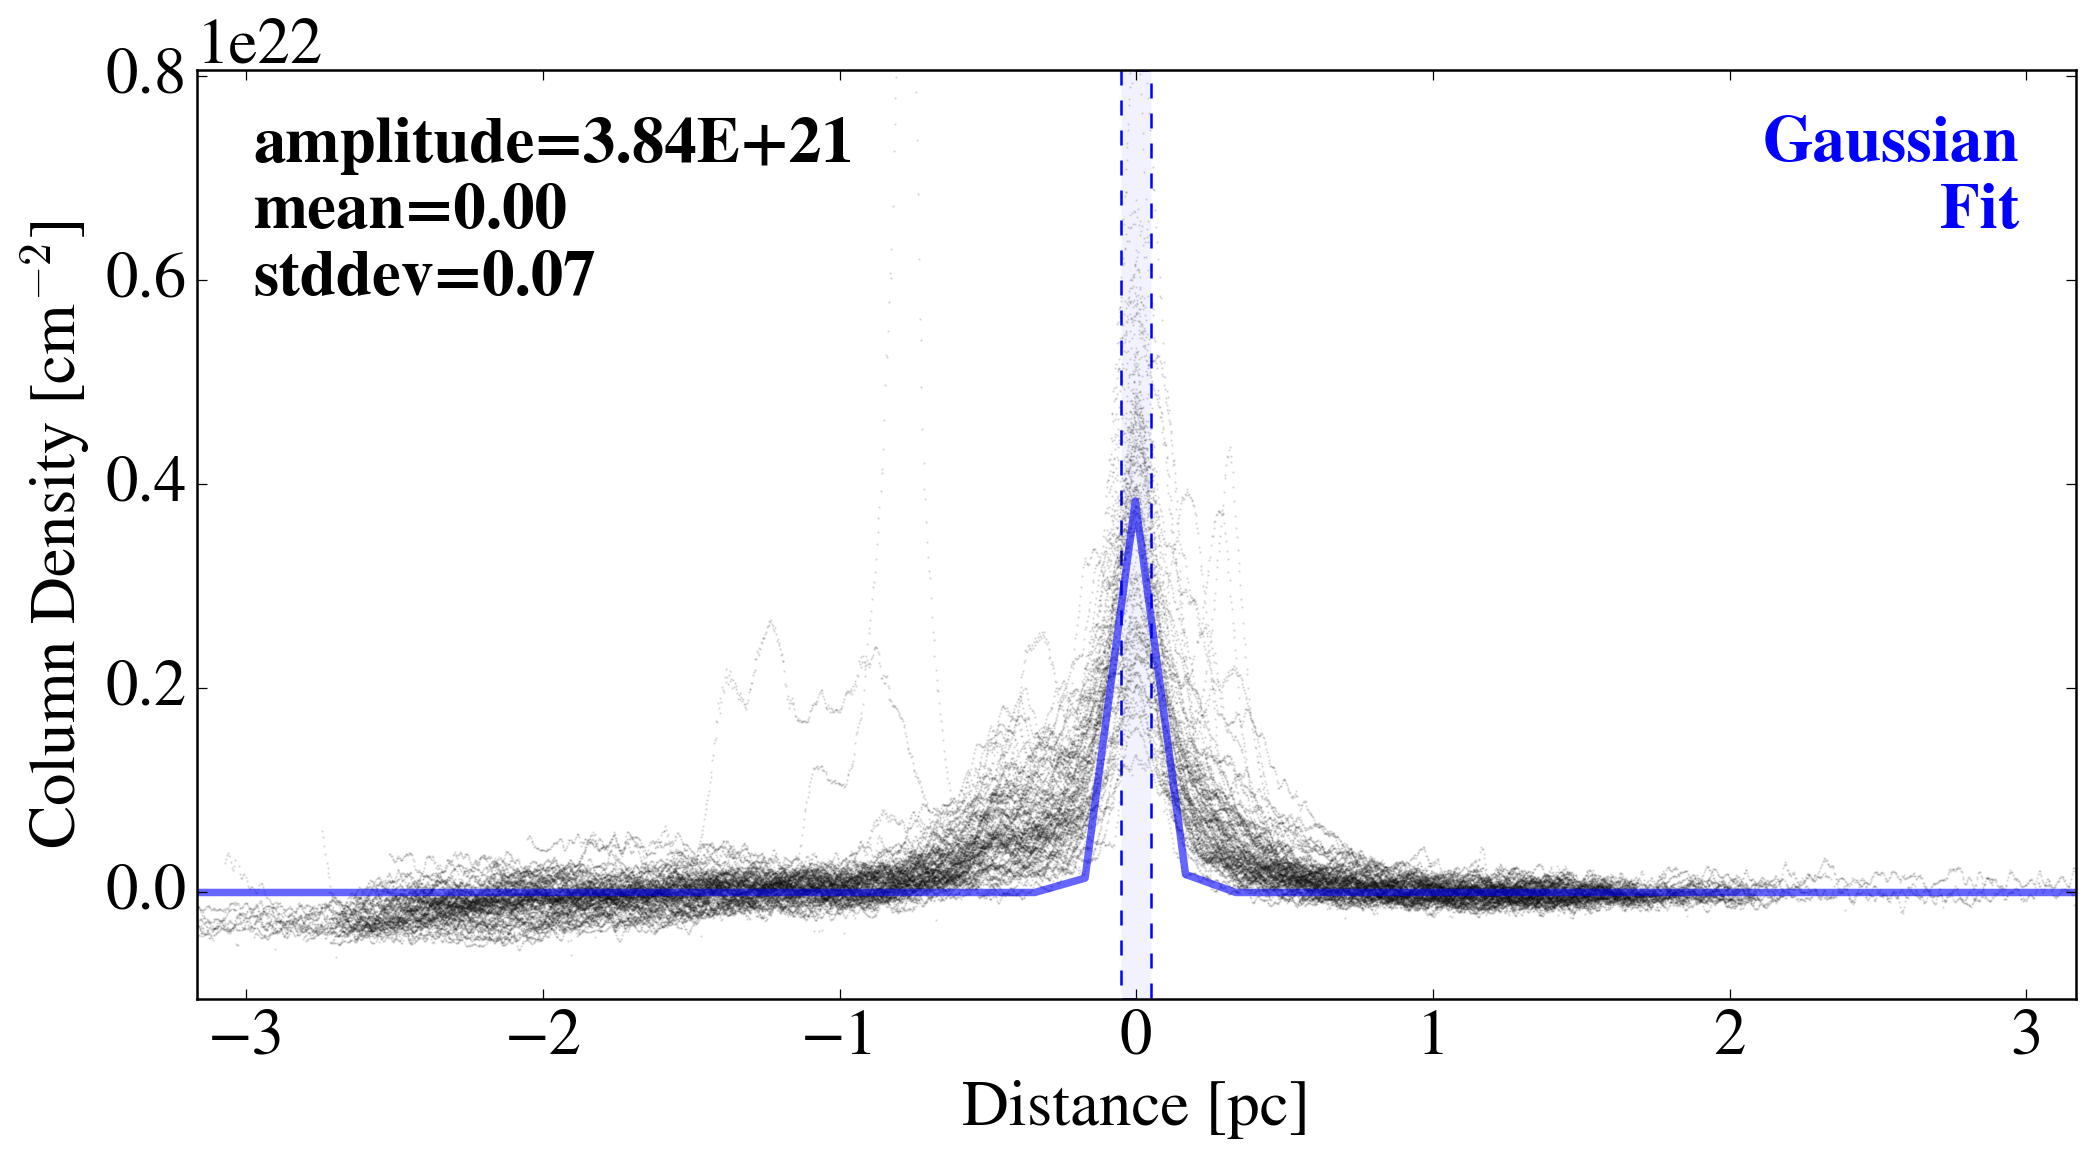

In [26]:
fig = plt.figure(figsize = (12., 6.))
ax = fig.gca()
ax.set_xlabel('Distance [pc]')
ax.set_ylabel('Column Density [cm$^{-2}$]')

radobj_plotter.plotFits(ax, 'model')